# Clase 16: Clustering K-means y Jerárquico

En esta notebook vamos a explorar dos métodos de clusterización vistos en la clase teórica. Los métodos de clusterización que veremos corresponden al rama de ML de aprendizaje no supervisado donde la idea principal es encontrar grupos en los datos que sean similares a otros datos del mismo grupo y lo menos similar posible a datos en otros.

El primer método es el algoritmo de partición **K-Means**, que aplicaremos al dataset de caras Olivetti, trabajado en notebook previas, para tratar de agrupar las fotos según la persona a la que se le sacó la foto.

El segundo es el método jerárquico **Hierarchical Clustering**, con la idea de segmentar clientes en distintos grupos basándonos en sus tendencias de compra. El dataset que utilizaremos en este caso es el "shopping_data.csv" que está subido a la carpeta de la materia.

In [ ]:
# importamos las librerías usuales de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    # K-means
from sklearn.cluster import AgglomerativeClustering   # Clustering jerárquico

Para agilizar el proceso de clusterización en el dataset de caras vamos identificar las componentes principales como en la clase pasada.

In [ ]:
# Clase para realizar componentes principales
from sklearn.decomposition import PCA

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador

## [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

El método de clusterización "K-Means" busca encontrar *k* clusters de modo tal que se minimice la varianza intra-cluster medida, usualmente, como el cuadrado de la distancia euclídea. Para ello el algoritmo empieza encontrando *k centroids* y le asigna a cada sample la etiqueta correspondiente a la del centroid más cercano. Una vez actualizadas las etiquetas de todas las samples, calcula la posición de los k centroids (como el promedio de las features de las samples de cada cluster) y vuelve a asignar etiquetas a cada sample de acuerdo a la distancia al centroid más cercano. Hace estos dos pasos hasta que no haya más cambios de etiqueta.

Debido a esta inicialización aleatoria de los k centroids el output del modelo puede variar al aplicarlo otra vez a la misma data. Por ello se repite este procedimiento n_init=10 veces y el output final es el que mejor resultado tuvo al minimizar la función objetivo (varianza intra-cluster).

### Clustering en el dataset de caras Olivetti

Importamos el dataset de caras Olivetti como en notebooks anteriores.

Recordamos eque el dataset consta de 10 fotos de 64*64 pixeles en escala de grises de 40 personas distintas. Cada sample (foto) importada es un vector de 4096 elementos, los cuales representan las filas de pixeles ordenadas de arriba hacia abajo de la foto. Es decir, los primeros 64 elementos corresponden a la fila superior de pixeles de la imagen y así sucesivamente.

In [ ]:
from sklearn.datasets import fetch_olivetti_faces # para cargar el dataset de caras
data, targets = fetch_olivetti_faces(return_X_y = True) # cargamos las caras

print('Dimensión de los datos {}'.format(data.shape))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Dimensión de los datos (400, 4096)


Antes que nada realizamos una descomposición en componentes principales. Notar que todos los features (pixeles) están en la misma escala (de 0 a 255) y por ese motivo no hacemos una normalización previa.

In [ ]:
# Creación del modelo de PCA con 100 componentes
pca = PCA(n_components = 100)

# Ajuste y transformación de los datos
pca.fit(data)
X_pca = pca.transform(data)

Chequeamos que la matriz X_pca tiene las dimensiones correspondientes (400 samples, 100 PCs)

In [ ]:
X_pca.shape

(400, 100)

Ploteamos el dataset en el espacio de las primeras dos componentes principales

Text(0, 0.5, 'Segunda componente principal')

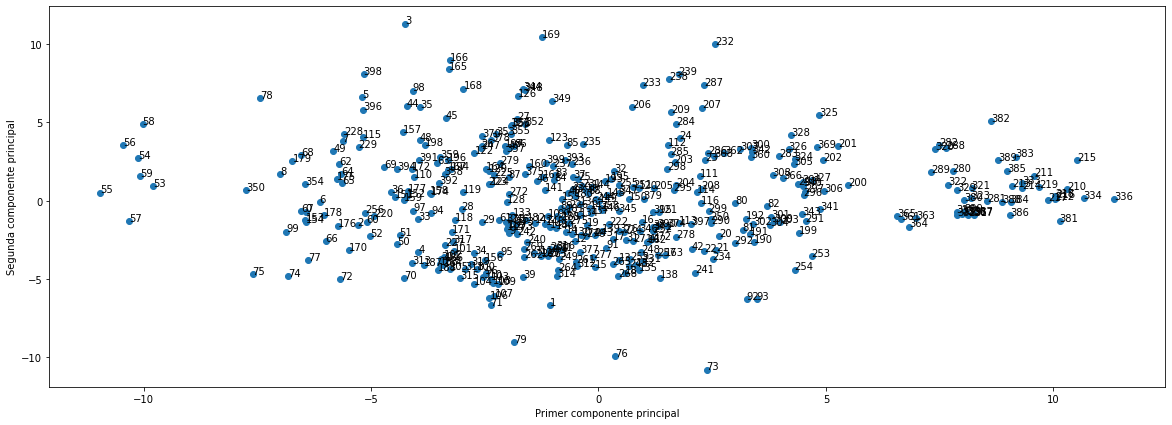

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Por cada dato escribimos a qué instancia corresponde
for i in range(data.shape[0]):
  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Ahora sí aplicamos el método de clusterización K-Means para agrupar las fotos en base a sus componentes principales. Como sabemos que el dataset consta de 40 personas diferentes utilizamos esta información para pedirle al algoritmo que encuentre k=40 clusters con la esperanza que podamos agrupar las fotos según la persona que está en ella.

In [ ]:
# Creación del modelo KMeans con k = 40
kmeans = KMeans(n_clusters=40)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

KMeans(n_clusters=40)

Para acceder a las etiquetas que le asignó el modelo a cada sample usamos 'kmeans.labels_'

In [ ]:
# Nos fijamos las etiquetas asignadas a las primeras 10 muestras y los counts que recibió cada una
np.unique(kmeans.labels_[:10], return_counts=True)

(array([ 6, 26, 28, 34], dtype=int32), array([3, 4, 1, 2]))

Idealmente queríamos tener una sola etiqueta en las primeras 10 muestras ya que corresponden a las fotos tomadas a una dada persona. Sin embargo obtuvimos 6 etiquetas distintas.

Veamos qué es lo que está pasando. Vamos a plotear el dataset en el espacio de las primeras dos componentes principales pero además vamos a asignarle un color a cada sample que corresponde a la etiqueta asignada por el modelo. También vamos a graficar con una "X" el centroid de cada cluster.

Para acceder a la posición de los centroids en el espacio de 100 PCs usamos 'kmeans.cluster_centers_'

In [ ]:
# Guardo las posiciones de los centroids
centroids = kmeans.cluster_centers_

# Printeo las dimensiones de las posiciones
print("Shape de los centroids:",centroids.shape)
# Printeo las posiciones de las primeras 5 muestras en sus primeras dos componentes principales
print(centroids[:5,[0,1]])

Shape de los centroids: (40, 100)
[[-2.6800363  -4.888303  ]
 [ 8.64359     1.4037197 ]
 [ 0.77757794  1.8912542 ]
 [ 1.1824912  -0.8524978 ]
 [-0.46458104  0.7546779 ]]


No handles with labels found to put in legend.


Text(0, 0.5, 'Segunda componente principal')

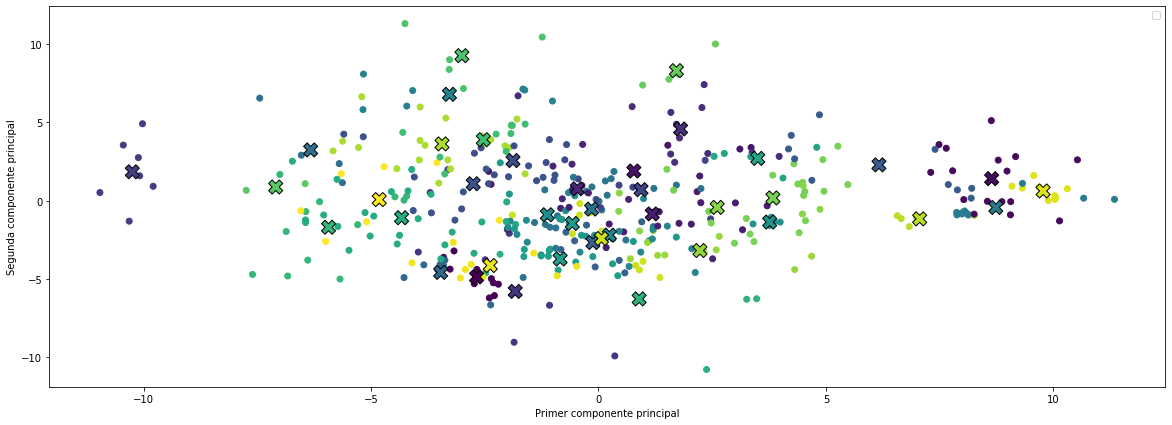

In [ ]:
# Este bloque es similar al anterior pero agregando color a cada sample en el scatter plot según la etiqueta asignada

fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black')
ax.legend()

## Por cada dato escribimos a qué instancia corresponde
#for i in range(data.shape[0]):
#  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

En este plot podemos ver que hay samples más alejados de la nube principal de puntos que tienen un color definido. Sin embargo más al centro del plot vemos que los colores se mezclan y esto se debe a que KMeans funciona bien cuando los grupos tienen forma de una esfera en n_features-dimensiones pero falla en otros casos.

Parecería ser que los clusters que encuentra no son los que queríamos que nos diera el modelo. Pero entonces, ¿qué son estos clusters? Plotiemos las imágenes correspondientes a cada cluster.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


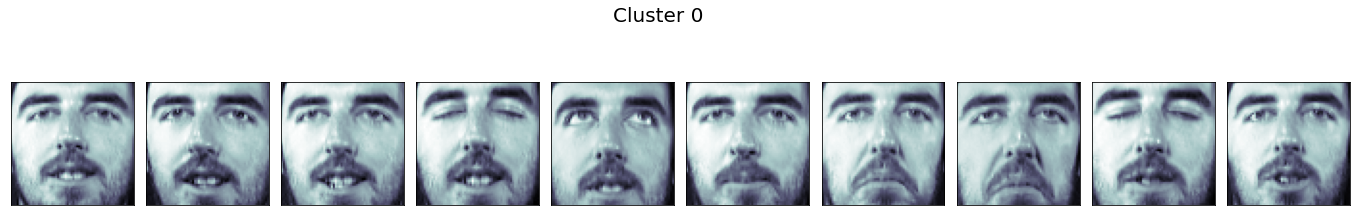

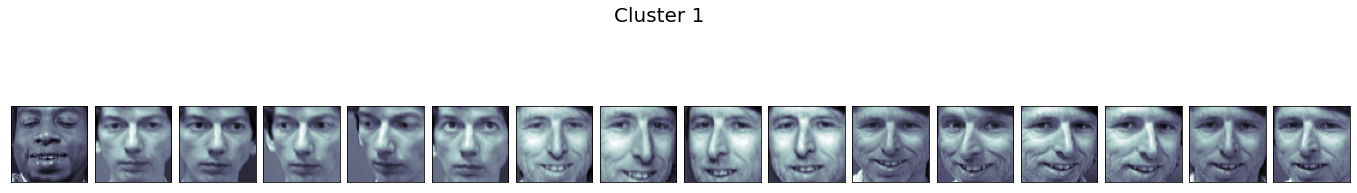

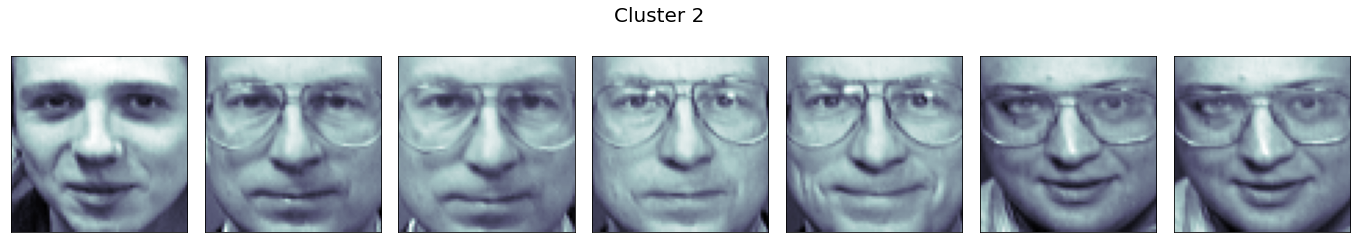

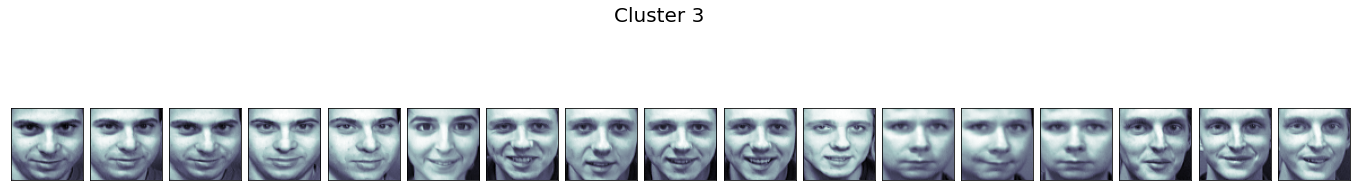

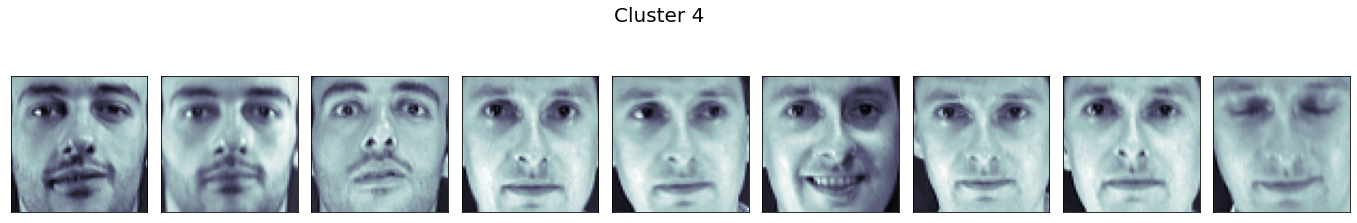

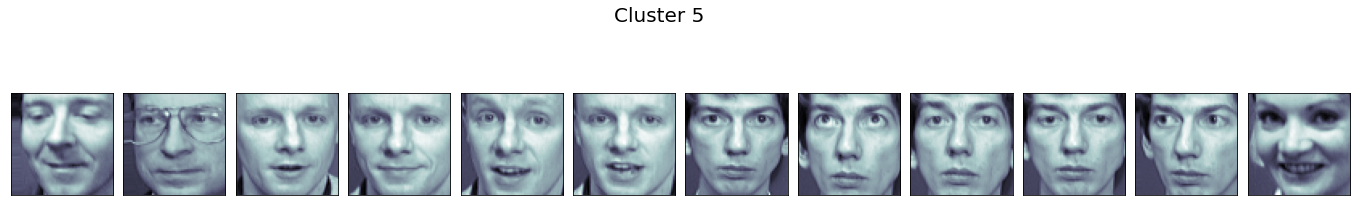

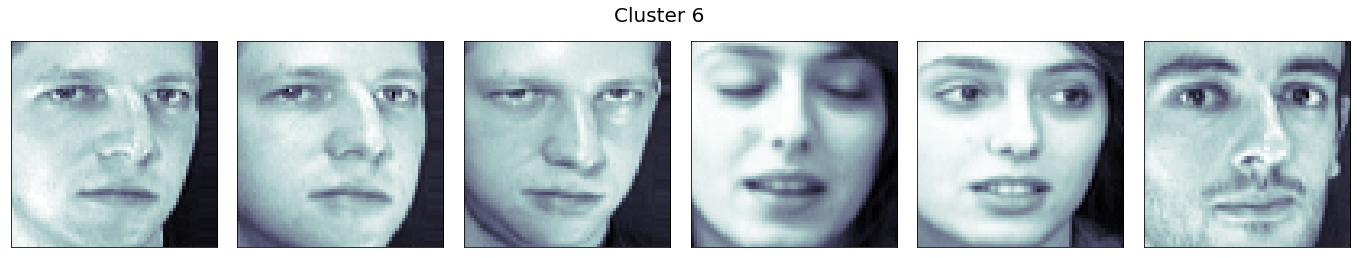

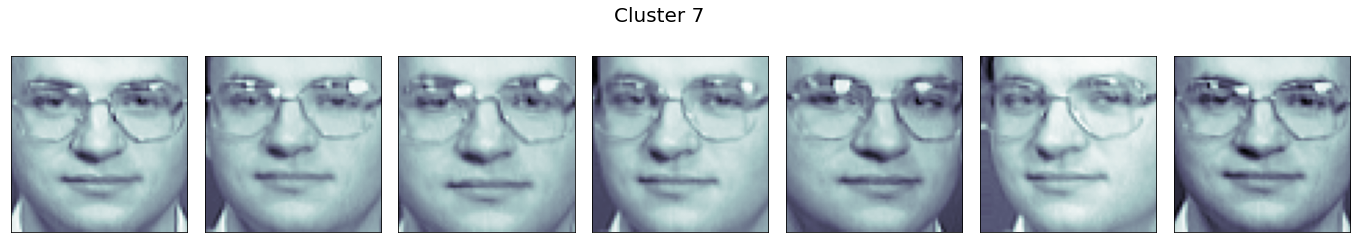

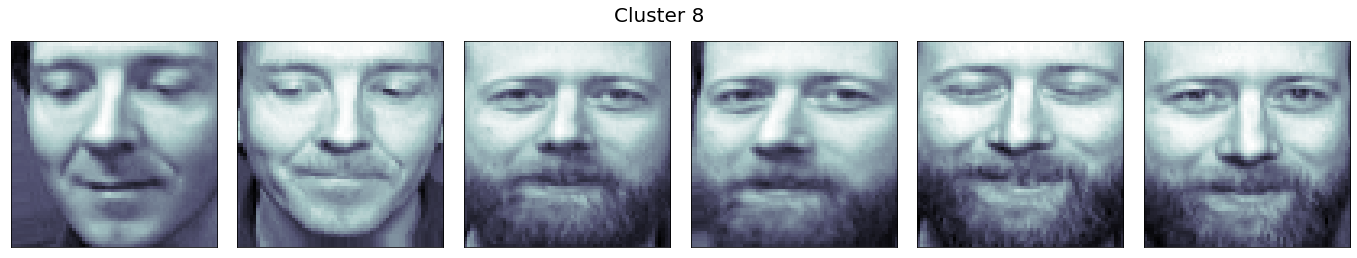

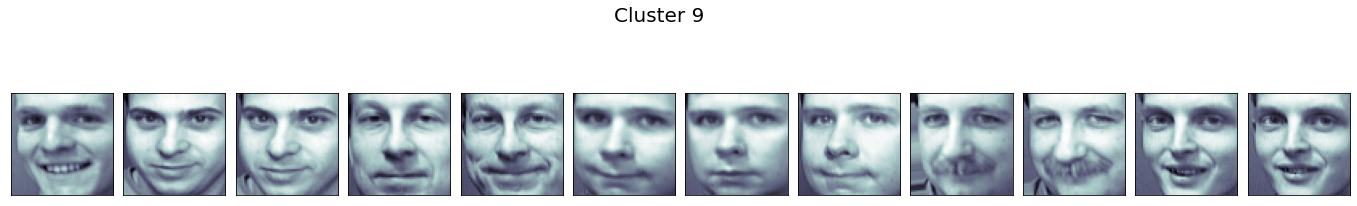

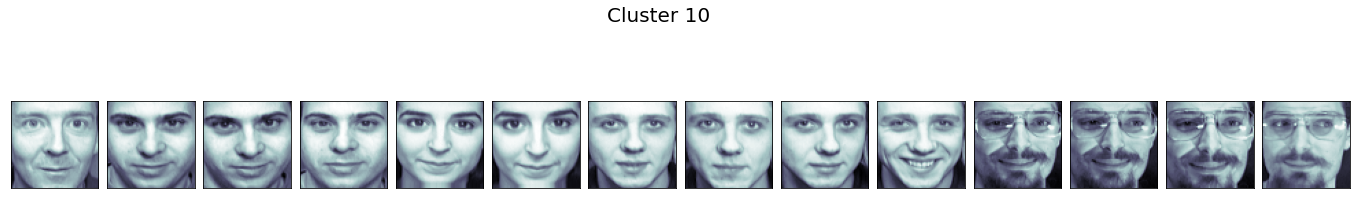

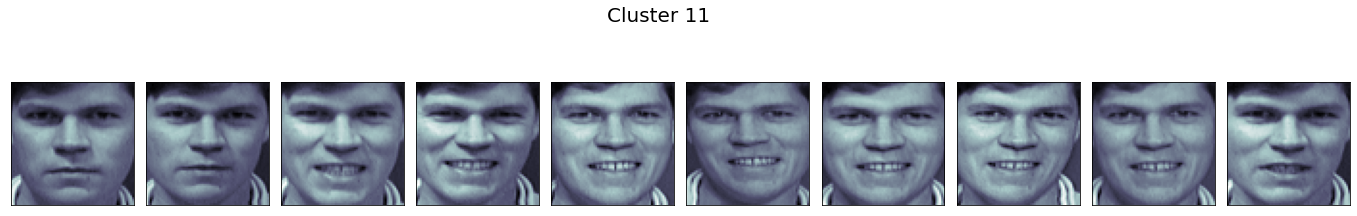

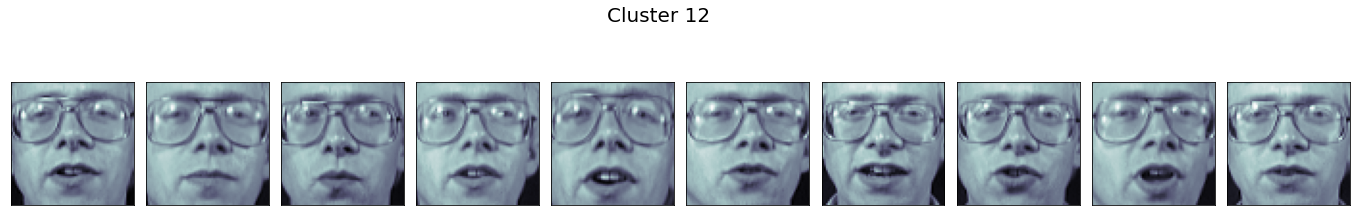

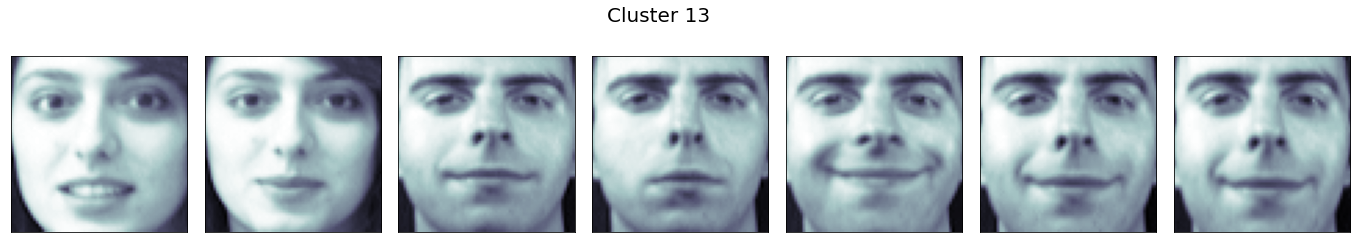

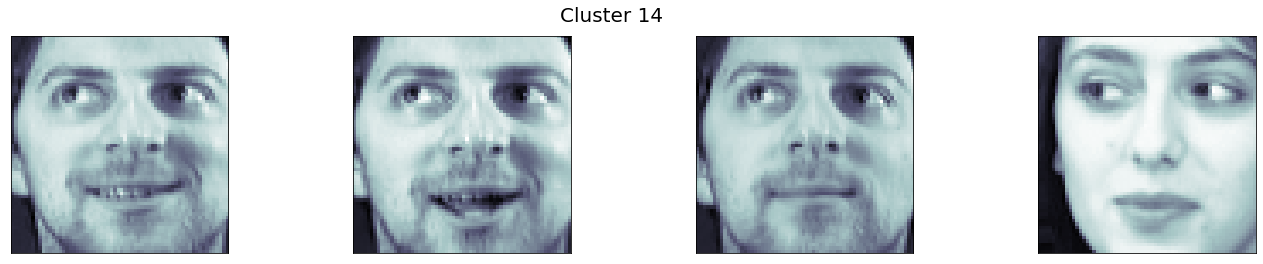

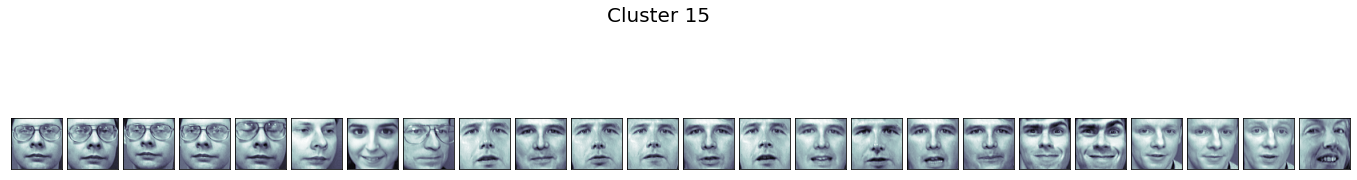

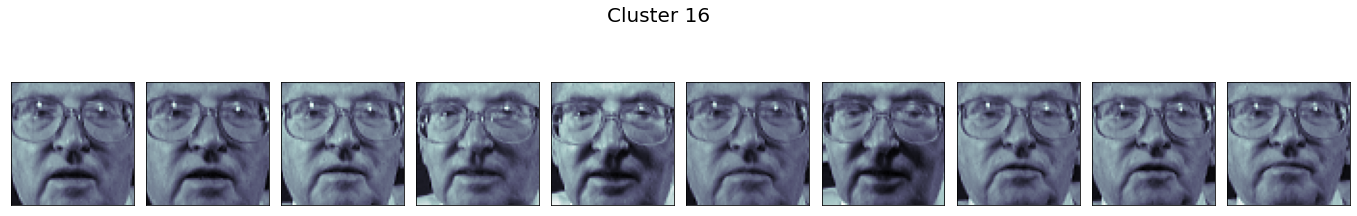

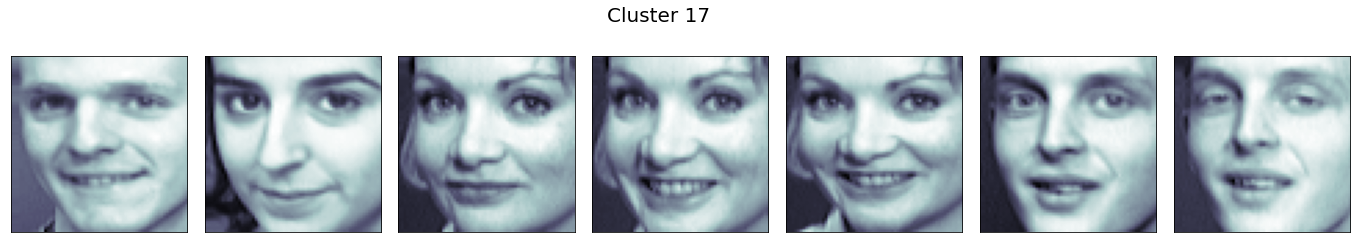

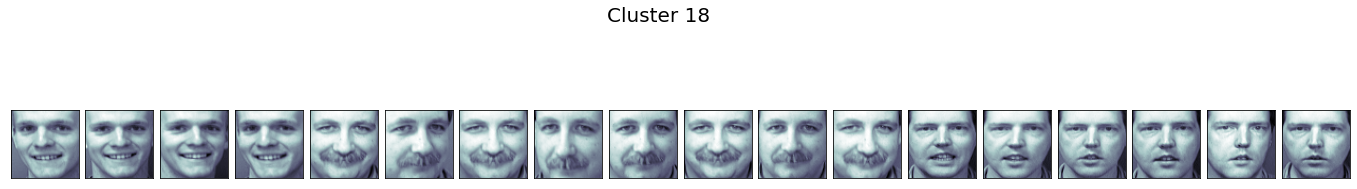

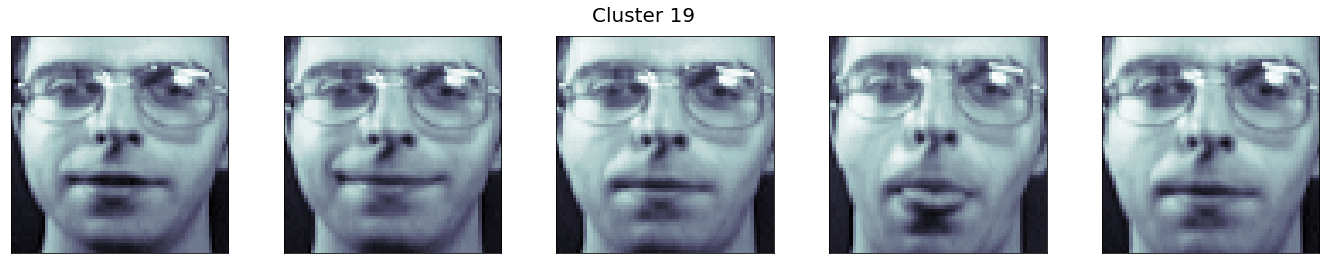

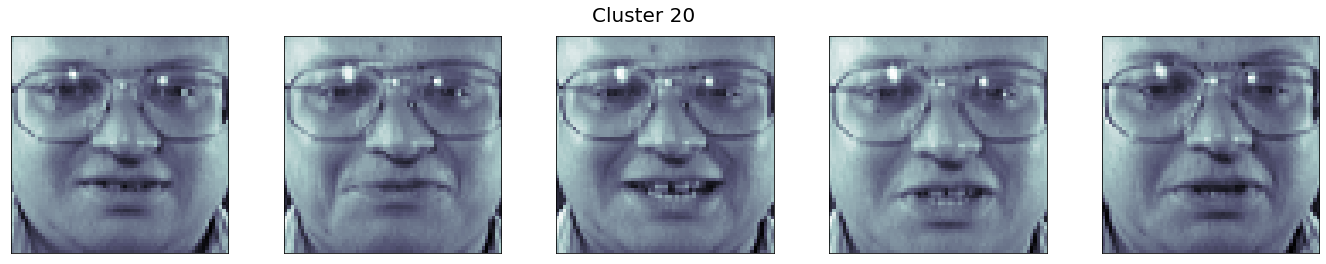

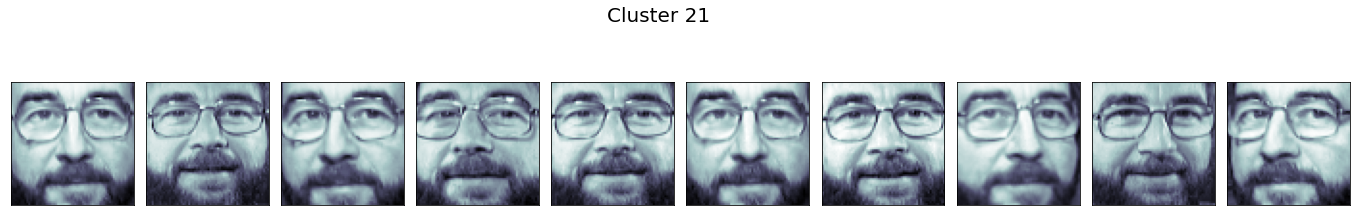

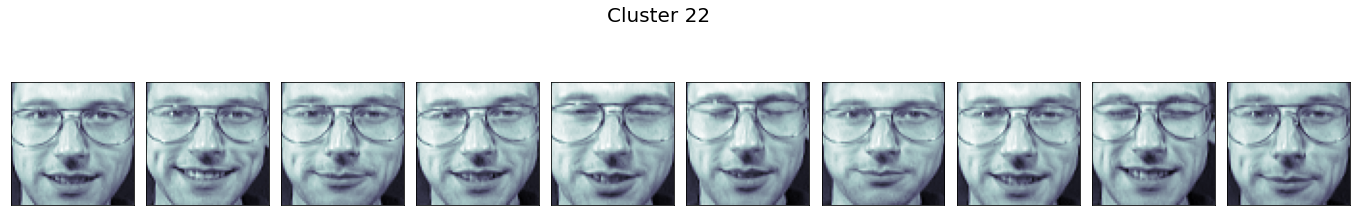

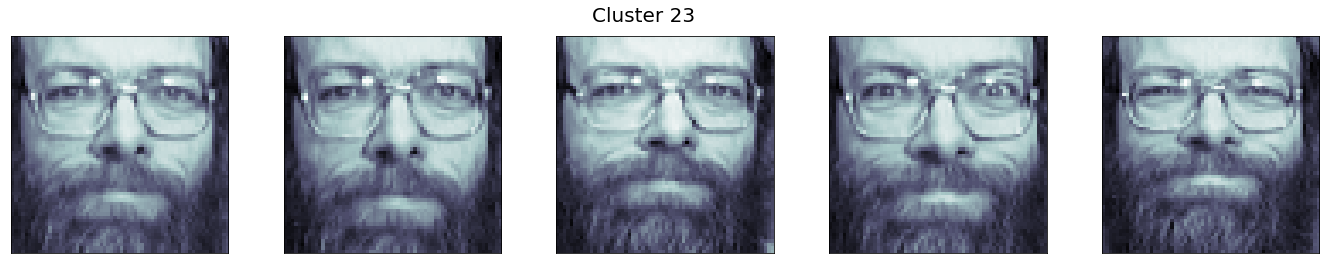

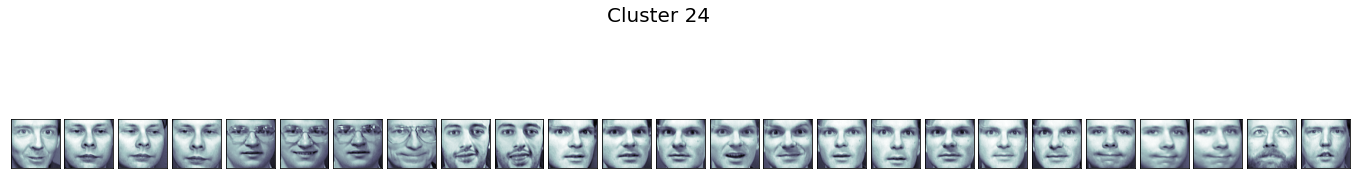

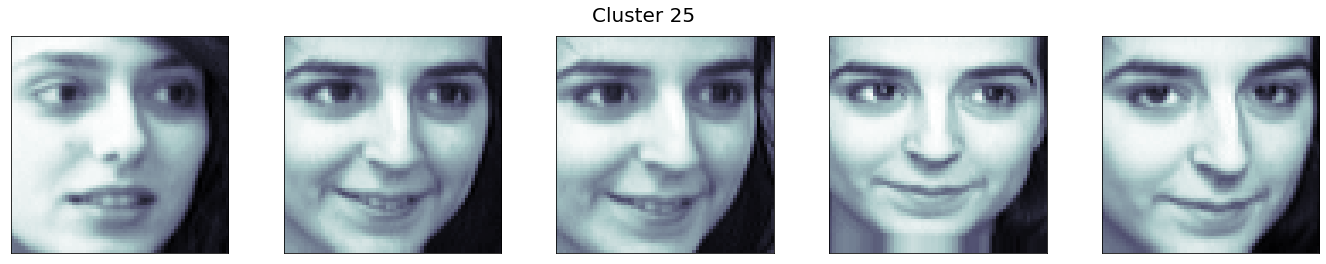

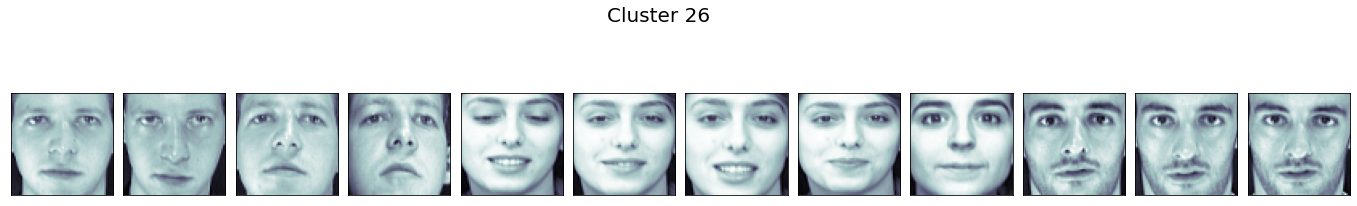

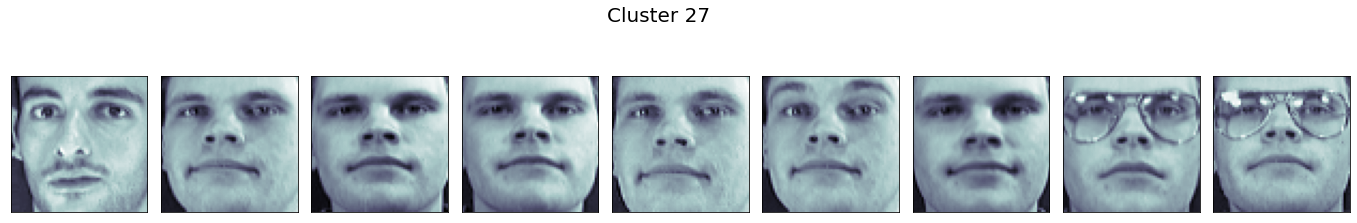

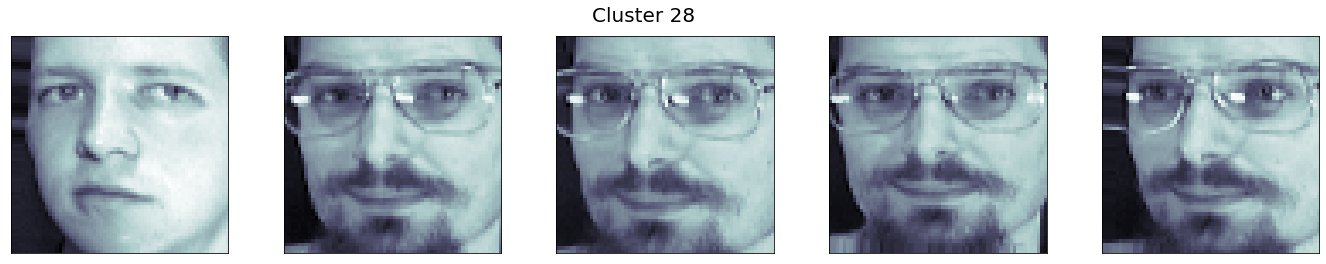

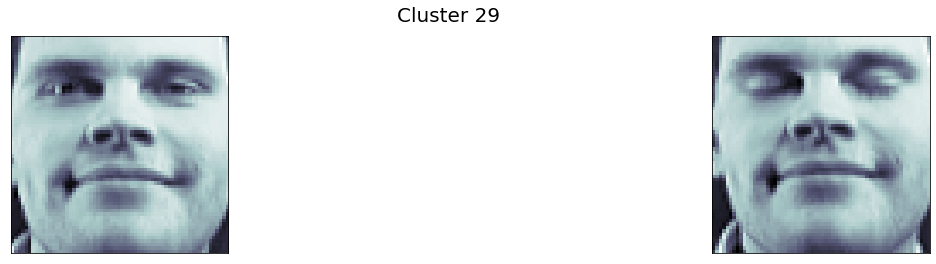

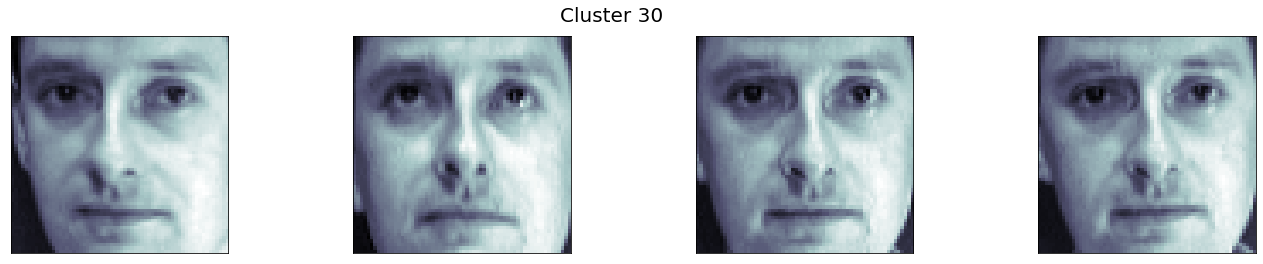

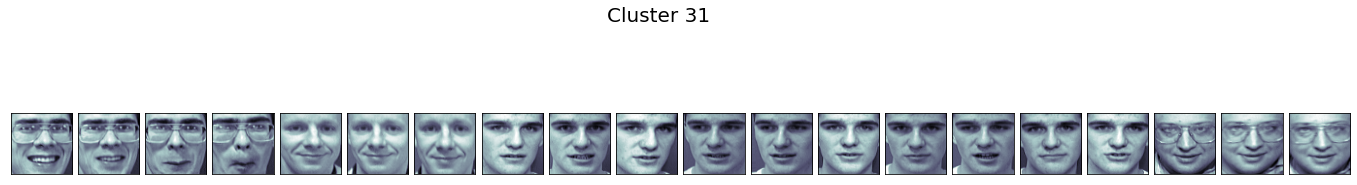

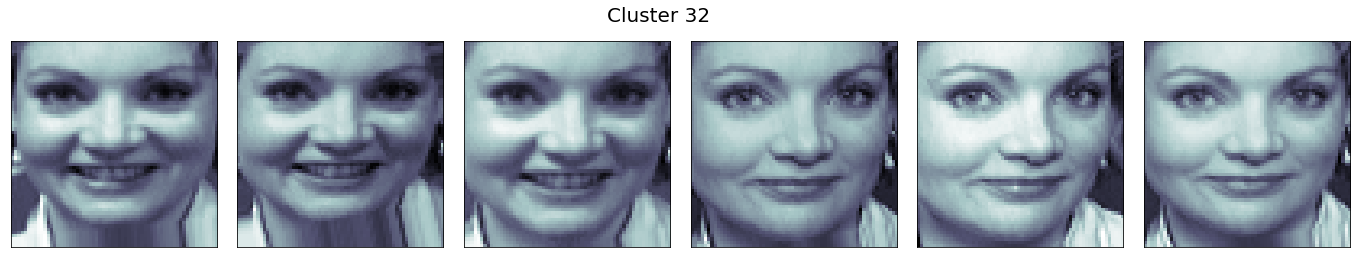

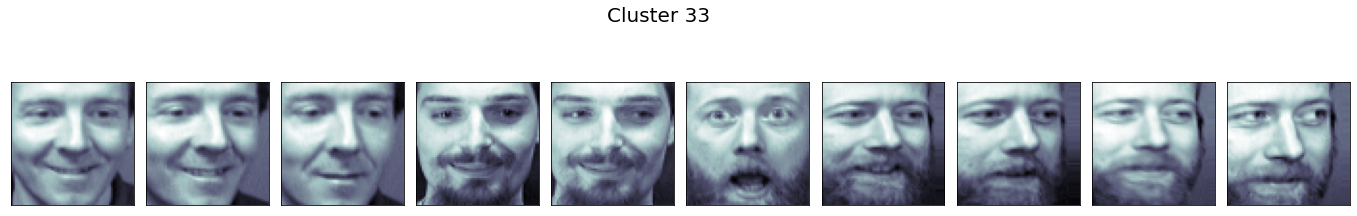

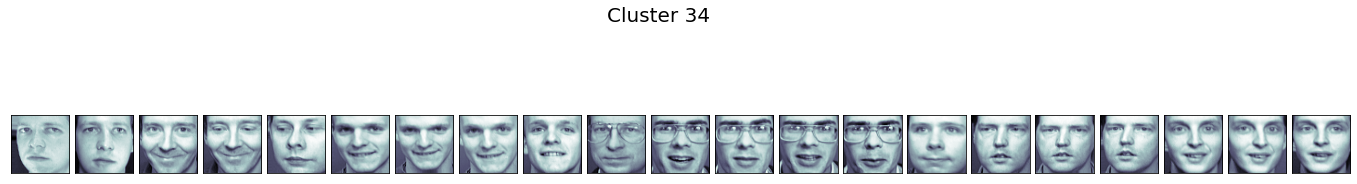

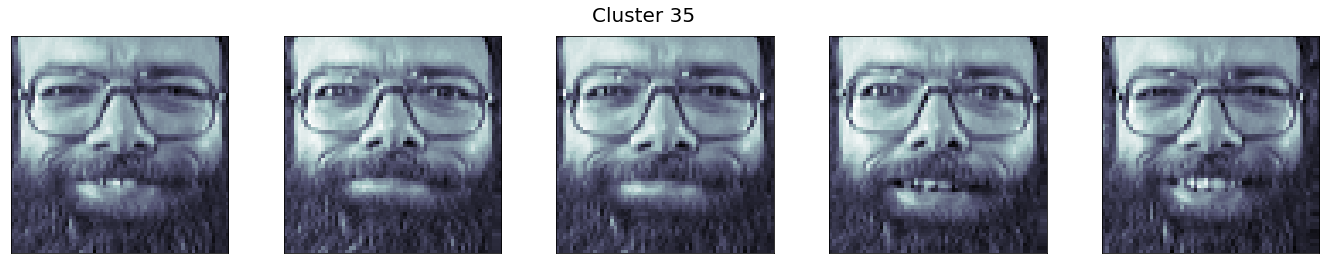

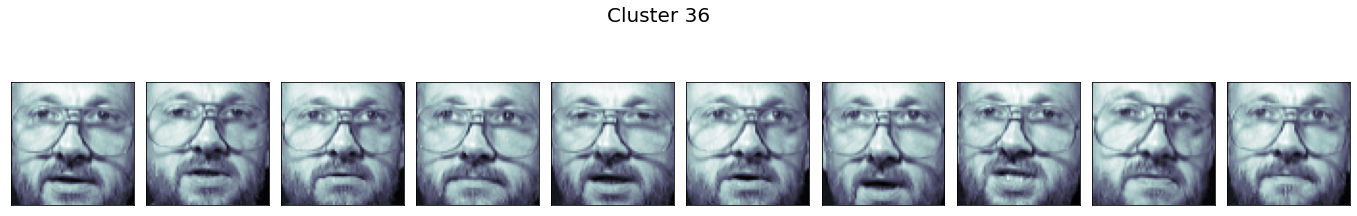

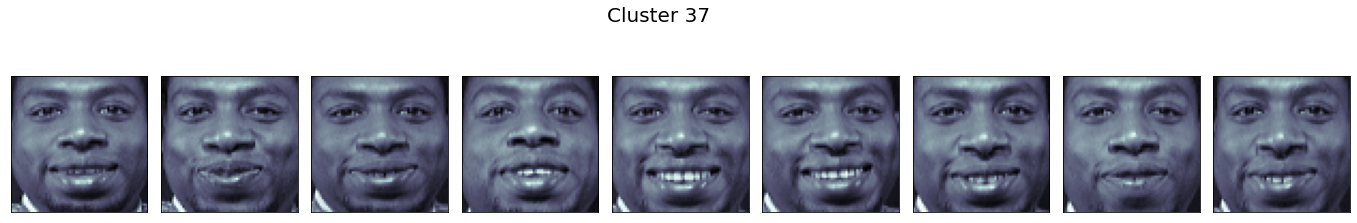

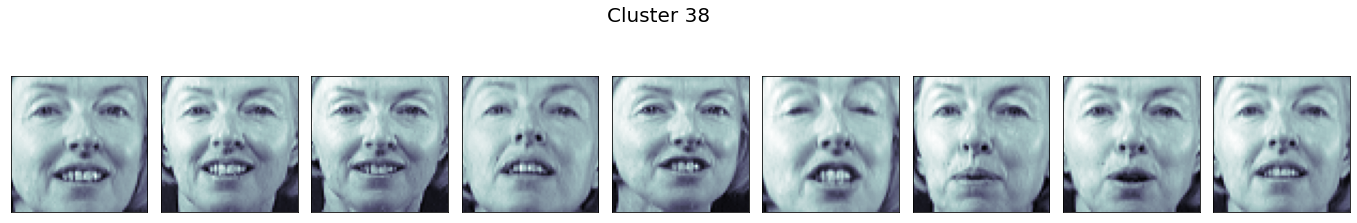

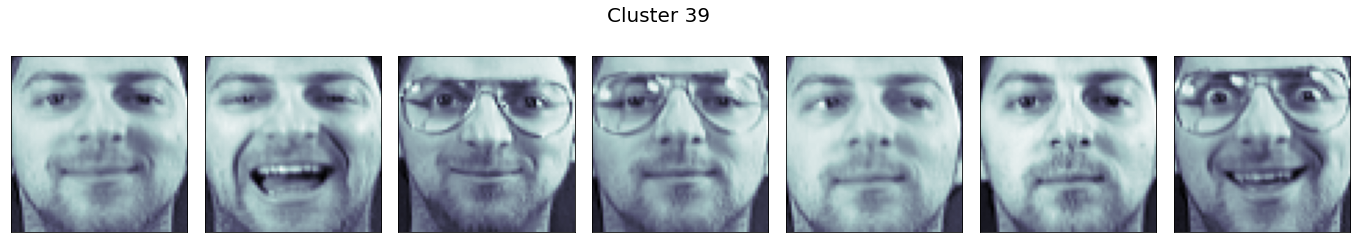

In [ ]:
# Mostrar el resultado final
labels = kmeans.labels_

# Iniciamos un for con k=40 iteraciones
for i in range(40):
    index = np.nonzero(labels==i)[0]                                    # los índices correspondientes a la i-ésima etiqueta
    num = len(index)                                                    # el número de samples en cada cluster
    this_faces = data[index].reshape(len(index),64,64)                  # reshapeamos los samples del i-ésimo cluster para que tenga el formato de una imagen de (64,64) pixeles
    fig, axes = plt.subplots(1, num, figsize=(24, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle("Cluster " + str(i), fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.imshow(this_faces[i], cmap='bone')

Vemos que varios de los clusters (ej: 11) sí corresponden a las fotos de una persona. Además en casi todos se puede entender por qué el método esta agrupando las fotos (ej: 9, se ven dientes en la sonrisa)

### Elección del número de clusters *k*

No hay un consenso en cómo elegir el parámetro *k* para el método KMeans. En algunos casos tenemos una idea de en cuántos grupos deberían estar divididos nuestros datos y simplemente elegimos ese número. Pero en muchos otros casos esta información no la tenemos al momento de hacer el clustering.

En esta parte vamos a ver dos approachs para la elección de k:
1. Método del codo
2. Coeficiente de Silhouette

#### 1 [Método del codo](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.)

Se hace un grafico de la función objetivo en función de la elección de k y se elige el k correspondiente al punto donde agregar un cluster más no baja significativamente el valor que queremos minimzar. Esto se puede detectar a ojo o utilizando algún paquete de python como ['kneed'](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf)

In [ ]:
!pip install kneed            # instalamos el paquete con pip
from kneed import KneeLocator # importamos el paquete para detectar el codo

Vamos a aplicar el método KMeans al dataset de caras pero cambiando el número de clusters k y guardaremos el puntaje de la función objetivo, SSE (suma de los cuadrados de la distancia euclidea de cada cluster), en una lista

In [ ]:
sse = [] # acá vamos a guardar el puntaje de la función objetivo

for k in range(1, 40):
  print(k)
  kkmeans = KMeans(n_clusters=k)
  kkmeans.fit(data)
  sse.append(kkmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Vamos a graficar SEE en función del número de clusters k

Text(0, 0.5, 'SSE')

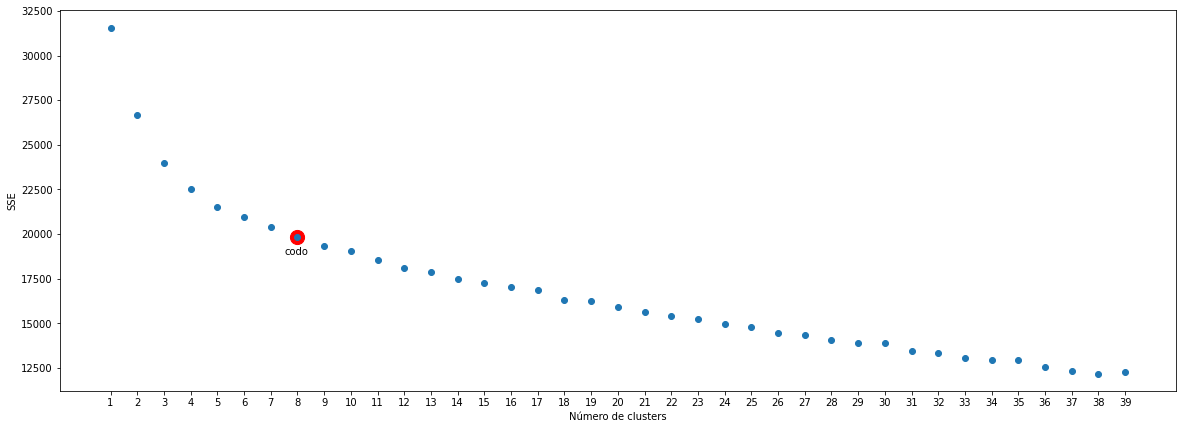

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))

# esta dos lineas las agrego para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(8, sse[7], color='red', s=200) # agregamos un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(7.5, sse[7]-1000, s="codo")       # agregamos un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SSEvsK
ax.scatter(range(1, 40), sse)
ax.set_xticks(range(1, 40))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("SSE")

En este plot podemos ver dos cosas:
1. SSE es monótonamente decreciente: al agregar un cluster la distancia entre todas las samples a los centroides siempre va a reducirse
2. A ojo distinguimos un codo entre k=5 y k=9 porque al agregar más clusters aumentamos la complejidad del modelo pero SEE disminuye en menor proporción

Usamos la función 'KneeLocator' para detectar el codo. Para ello le tenemos que pasar los valores de K, SEE, la forma de la fución (cóncava o convexa) y la dirección (creciente o decreciente)

In [ ]:
kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)

El codo está en k = 11


Veamos entonces cómo se ve el modelo con k=8 para el dataset de caras Olivetti

No handles with labels found to put in legend.


Text(0, 0.5, 'Segunda componente principal')

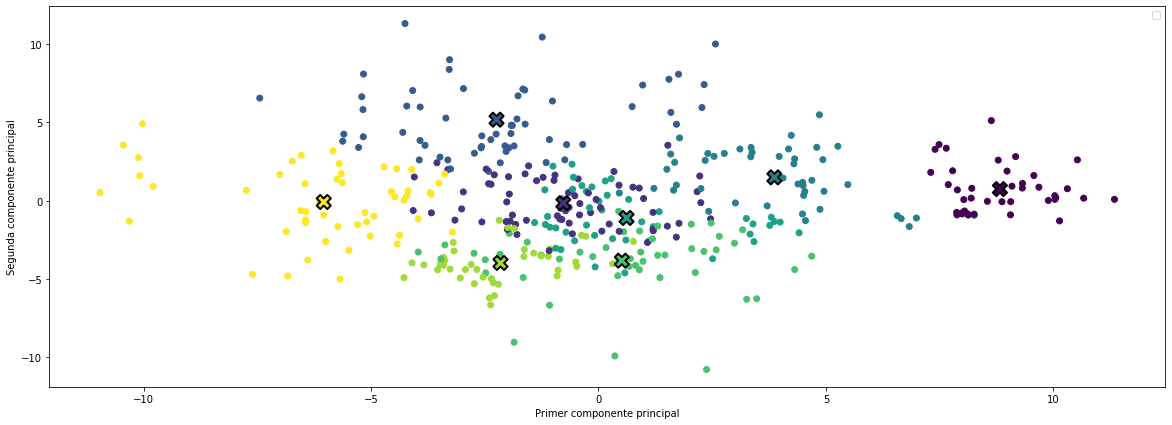

In [ ]:
# Creación del modelo KMeans con k = 8
kmeans8 = KMeans(n_clusters=8)

# Ajuste del modelo a los datos reducidos en componentes principales
kmeans8.fit(X_pca)

# Guardamos la posición de los centroids
centroids8 = kmeans8.cluster_centers_

# Plot
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans8.labels_)
ax.scatter(centroids8[:, 0], centroids8[:, 1], marker="X", s=200, linewidths=2,
            c=np.unique(kmeans8.labels_),edgecolors='black')
ax.legend()

## Por cada dato escribimos a qué instancia corresponde
#for i in range(data.shape[0]):
#  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

#### 2 Coeficiente de Silhouette

El coeficiente de Silhouette mide qué tan cerca está una muestra a las otras muestras de su cluster y qué tan lejos está con respecto a las muestras del cluster más cercano. Este coeficiente toma valores de [-1,1], -1 sería si los clusters están superpuestos, 0 si hay overlap y 1 que no se tocan.

El coeficiente de Silhouette de cada sample la podemos obtener con la clase 'silhouette_samples' de sklearn.metrics

El puntaje de Silhouette es el promedio de los coeficientes de Silhouette de todas las samples y se computa con la clase 'silhouette_score' de sklearn.metrics. Hay que pasarle a la función los datos y sus etiquetas.

In [ ]:
# importamos el puntaje de silhouette
from sklearn.metrics import silhouette_score

In [ ]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k
silhouette_coefficients = []

# Se necesita tener al menos 2 clusters y a los sumo N-1 (con N el numero de muestras) para obtener coeficientes de Silohuette
for k in range(2, 20):
     kkkmeans = KMeans(n_clusters=k)
     kkkmeans.fit(data)
     score = silhouette_score(data, kkkmeans.labels_)
     silhouette_coefficients.append(score)

Graficamos el puntaje de Silhouette en función de k

Text(0, 0.5, 'Promedio coeficientes de Silhouette')

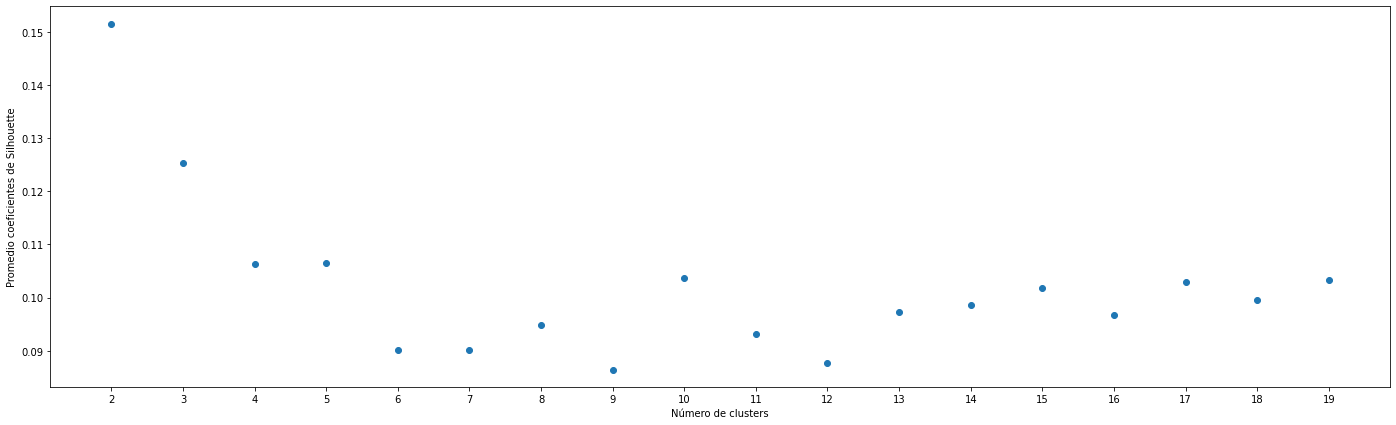

In [ ]:
fig, ax = plt.subplots(figsize = (24, 7))

# estas lineas son el grafico de SSEvsK
ax.scatter(range(2, 20), silhouette_coefficients)
ax.set_xticks(range(2, 20))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("Promedio coeficientes de Silhouette")

In [ ]:
kklabels = kkkmeans.labels_
kkklabels = kklabels.copy()

np.random.shuffle(kkklabels)

silhouette_score(data, kkklabels)

-0.09741924

En este plot vemos que el puntaje de Silhouette < 0.2 y tiene poca desviación.

Se puede decir que **no se encuentran estructuras fuertes en los datos** y es necesaria una *inspección manual* de ellos para determinar el número óptimo de clusters (y/o probar con otros métodos). Sin embargo en muchos dataset reales va a pasar que no todo se puede hacer de manera automática y se debe tener intuición o noción de lo que están representando los datos para un realizar un análisis correcto.

## [Clustering Jerárquico](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

Los métodos de clustering jerárquico buscan agrupar las samples más similares para formar grupos con características similares.

1. **Agglomerative**: cada sample es un cluster y en cada paso va agrupando los clusters más similares hasta quedarse con un solo cluster
2. **Divisive**: todas las samples comienzan en el mismo cluster y en cada paso va cortando las samples menos similares hasta que todas las samples sean un cluster distinto

En esta notebook vamos a ver el primer tipo de clustering jerárquico aplicado a un dataset de tendencias de compra de clientes de un shopping

In [ ]:
# Montamos el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path de nuestro dataset
filename = '/content/drive/My Drive/LaboDatos2022/shopping_data.csv'

# Carga del dataset
df = pd.read_csv(filename)

# Inspecciono las primeras filas
df.head()

CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

In [ ]:
print("Dimensiones del dataset:",df.shape)

Dimensiones del dataset: (200, 5)


Este dataset tiene de features una ID asociada a cada uno de los 200 clientes, el género binario, la edad de la persona, el ingreso anual (en miles de dolares) y un puntaje asociado a cuán a menudo un cliente gasta plata en el shopping siendo 100 el cliente que más gasta.

Vamos a tratar de agrupar a los clientes utilizando solo dos features del dataset: su ganancia anual y el puntaje de gastos

In [ ]:
# Me armo una matriz con las ultimas dos columnas del dataframe
sdata = df.iloc[:,3:5].values

sdata[:5]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40]])

Importamos un paquete de scipy que nos va a ayudar a plotear dendogramas. Lo importamos entero porque vamos a usar dos de sus clases 'dendogram' y 'linkage'.

In [ ]:
# Paquete de scipy que tiene la clase 'dendograma' que vamos a utilizar
import scipy.cluster.hierarchy as shc

Vamos a realizar un dendograma del dataset utilizando el método 'ward' para calcular distancias (es el que se suele ultilizar y viene por default). Este método minimiza la varianza dentro de un cluster y maxima la varianza entre clusters.

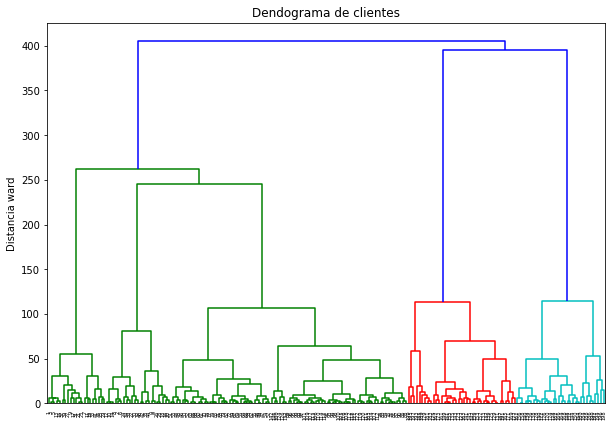

In [ ]:
# Plot del dendograma del dataset de clientes
plt.figure(figsize=(10, 7))
plt.title("Dendograma de clientes")
plt.ylabel("Distancia ward")

# Con la función 'dendogram' graficamos el dendograma.
dend = shc.dendrogram(shc.linkage(sdata, method='ward'))  # El input de esta función es la función 'linkage' donde se especifica la distancia para utlizar en cada paso del método

Lo que buscamos en el dendograma es la mayor distancia vertical sin que haya una línea horizontal para hacerle un corte (representado como una linea horizontal que cruza todos los datos) y quedarnos con k clusters (donde k es el número de lineas verticales que intersectan el corte.

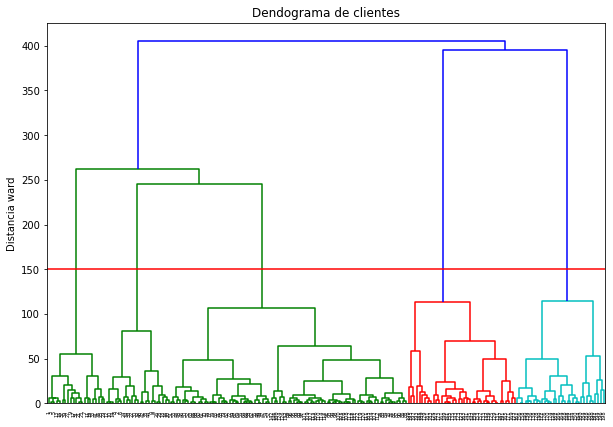

In [ ]:
# Plot del dendograma del dataset de clientes
plt.figure(figsize=(10, 7))
plt.title("Dendograma de clientes")
plt.ylabel("Distancia ward")

# Con la función 'dendogram' graficamos el dendograma.
dend = shc.dendrogram(shc.linkage(sdata, method='ward'))  # El input de esta función es la función 'linkage' donde se especifica la distancia para utlizar en cada paso del método
plt.axhline(150, c='r')

Vemos que el corte intersecta con 5 líneas verticales por lo que vamos a utilizar el método de clustering jerárquico de sklearn con n_clusters=5

In [ ]:
# Importo el método de clustering jerárquico (bottom-up)
from sklearn.cluster import AgglomerativeClustering

Ahora sí aplicamos el método de clusterización jerárquica (bottom-up) con 5 clusters, la distancia euclidea para la afinidad y la distancia ward para el linkage

In [ ]:
# Creamos el modelo
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

# Lo ajustamos con los datos
cluster.fit_predict(sdata)  # fit_predict hace lo mismo que fit pero devuelve el vector de etiquetas de las samples

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

Veamos cómo se ven los datos agrupados en el espacio de features

Text(0, 0.5, 'Puntaje de gastos')

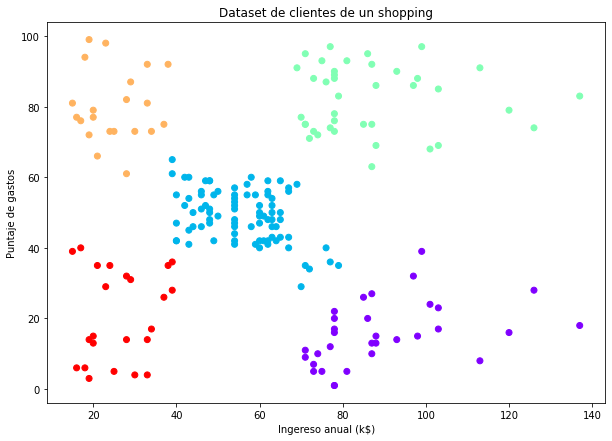

In [ ]:
# Ploteamos los datos en el espacio de (Ingresos,Gastos) con un color por cada uno de los 5 clusters
plt.figure(figsize=(10, 7))
plt.title("Dataset de clientes de un shopping")
plt.scatter(sdata[:,0], sdata[:,1], c=cluster.labels_, cmap='rainbow')
plt.xlabel("Ingereso anual (k$)")
plt.ylabel("Puntaje de gastos")

El cluster violeta, abajo a la derecha, corresponde a clientes con salarios altos pero que gastan poco en el shopping. Estos son clientes que gastan con cuidado su dinero.

El cluster verde clarito representa a clientes con mucho salario y que gastan hasta el último centavo en bobadas. Estos son los tipos de clientes que una compañía busca para llenarlos de publicidad.

El cluster celeste es el de clientes 'promedio'. El mayor numero de samples cae dentro de este cluster y por eso también son el objetivo de compañías que buscan llegar a mucha gente.

## Cosas para llevarse de esta notebook

KMeans

```
from sklearn.cluster import KMeans  # Importamos la clase KMeans

kmeans = KMeans(n_clusters=k)       # Crear el modelo con k-clusters

kmeans.fit(datos)                   # Ajustar el modelo a los datos

labels = kmeans.labels_             # Obtener las etiquetas de los k clusters para cada sample

centroids = kmeans.cluster_centers_ # Obtener las posiciones en el espacio de features del centro de los k clusters

sse = kmeans.inertia_               # Para obtener el valor de la función objetivo
```

Elección de k (si no lo conocemos de antemano):

Método del codo

```
!pip install kneed            # Instalamos el paquete kneed con pip install

from kneed import KneeLocator # Importamos la clase para detectar el codo

kl = KneeLocator(range(1, 40), sse, curve="convex", direction="decreasing") # Clase que sirve para calcular el codo en un gráfico de la función objetivo. Se le dan los puntos de la función con sus respectivos k, el tipo de curva (convexa o cóncava) y el sentido (creciente o decreciente)

kl.elbow                      # Devuelve el valor del codo
```

Puntaje de Silhouette

```
from sklearn.metrics import silhouette_samples # importamos la clase que computa el coeficiente de silhouette para cada sample

from sklearn.metrics import silhouette_score # importamos la clase con la que se calcula el puntaje de silhouette (que es el promedio de los coeficientes de silhouette para cada sample)

silhouette_score(data, kkkmeans.labels_) # Devuelve el puntaje de silhouette y toma como input los datos y las etiquetas asociadas
```

Clustering Jerárquico

```
import scipy.cluster.hierarchy as shc # Paquete de scipy que tiene la clase 'dendograma' y 'linkage' que vamos a utilizar

dend = shc.dendrogram(shc.linkage(data, method='ward')) # Para hacer un dendograma de los datos usnado como linkage la distancia ward

from sklearn.cluster import AgglomerativeClustering # Importo el método de clustering jerárquico (bottom-up)

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') # Creamos el modelo

cluster.fit_predict(sdata)  # Ajustamos el modelo. '.fit_predict' hace lo mismo que '.fit' pero imprime el vector de etiquetas de las samples
```




## Ejercicios propuestos

* Realizar una clusterización mediante KMeans en el dataset 'shopping_data.csv' y comparar el resultado con el de clusterización jerárquica. Pensar qué pasaría en ambos casos ante la presencia de outliers. Testear la robustez de ambos métodos aplicándolos a subsets de 80% de los datos originales.
* Estandarizar el dataset de caras Olivetti y repetir el procedimiento propuestos en esta notebook. Visualizar los plots correspondientes al método del codo y coeficiente de Silhouette.
* Aplicar alguno de los algoritmos de clusterización propuestos en esta notebook en otro dataset de los vistos en clase. Es necesario realizar la descomposición en componentes principales antes de la clusterización? Comparar el tiempo que tarda el método con y sin la reducción de dimensionalidad.